# Inspecting the extracted colors from the dataset

# PCA space

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# for the 3d histogram
from mpl_toolkits.mplot3d import Axes3D
from skimage.color import lab2rgb

In [2]:
color_df = pd.read_csv('../filtered_labeled_data.csv')

In [3]:
lab_vals = [i.strip("()").split(', ') for i in color_df.lab]
lab_vals = np.array([[int(i) for i in q] for q in lab_vals])

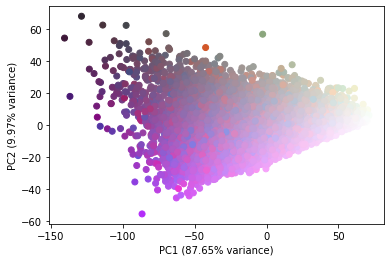

In [4]:
pca = PCA(n_components=2)
components = pca.fit_transform(lab_vals,)

# plot pc1 and 2
fig, ax = plt.subplots()
ax.scatter(components[:,0], components[:,1], c=color_df.hex)#, edgecolor='black')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
plt.show()

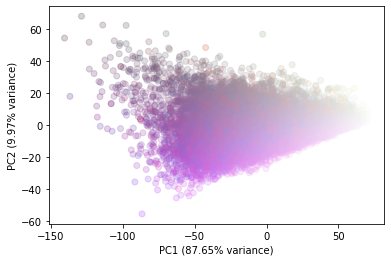

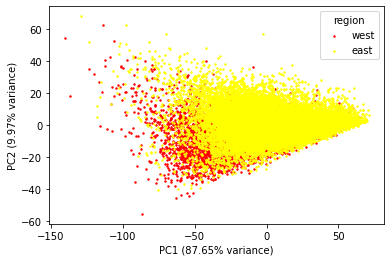

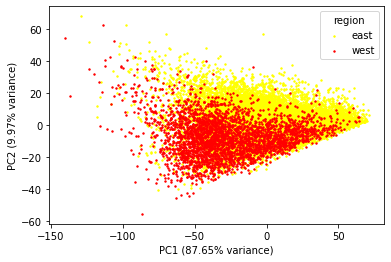

In [5]:
# do pca
pca = PCA(n_components=2)
components = pca.fit_transform(lab_vals)

# add to df
color_df['PC1'] = components[:, 0]
color_df['PC2'] = components[:, 1]

# split df into two regions
west = color_df[color_df['longitude'] <= -100]
#west = west.sample(1500)
east = color_df[color_df['longitude'] > -100]
#east = east.sample(1500)

# plots pc1 and 2
fig, ax = plt.subplots()
ax.scatter(components[:,0], components[:,1], c=color_df.hex,alpha=0.2)#, edgecolor='black')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
plt.show()

### west and east
fig, ax = plt.subplots()

# plot west points with red
ax.scatter(west['PC1'], west['PC2'], c='red', marker='o', label='west',alpha=1,s=2)

# plot east points with yellow
ax.scatter(east['PC1'], east['PC2'], c='yellow', marker='o', label='east',alpha=1,s=2)

# labels legend
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
ax.legend(title='region')
plt.show()

### west and east (reverse order)
fig, ax = plt.subplots()

# plot east points with yellow
ax.scatter(east['PC1'], east['PC2'], c='yellow', marker='o', label='east',alpha=1,s=2)

# plot west points with red
ax.scatter(west['PC1'], west['PC2'], c='red', marker='o', label='west',alpha=1,s=2)

# labels legend
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
ax.legend(title='region')
plt.show()

# Plot 3D histograms to better capture density of purples relative to other outlier colors

In [6]:
lab_vals = np.array([[int(h) for h in q] for q in [i.strip('()').split(', ') for i in color_df.lab]])

In [7]:
lab_vals[:,[1,2]]

array([[138, 118],
       [143, 119],
       [149, 104],
       ...,
       [149, 103],
       [131, 135],
       [151, 107]], shape=(20628, 2))

In [8]:
## we need to reformat the lab values to what 
# the skimage library expects (from opencv)

# separate out for simplicity, make them floats
L_raw = lab_vals[:, 0].astype(float)
a_raw = lab_vals[:, 1].astype(float)
b_raw = lab_vals[:, 2].astype(float)

# convert to true Lab floats (from 0-255 prev)
L =  (L_raw / 255.0) * 100.0
a =  a_raw - 128.0
b =  b_raw - 128.0

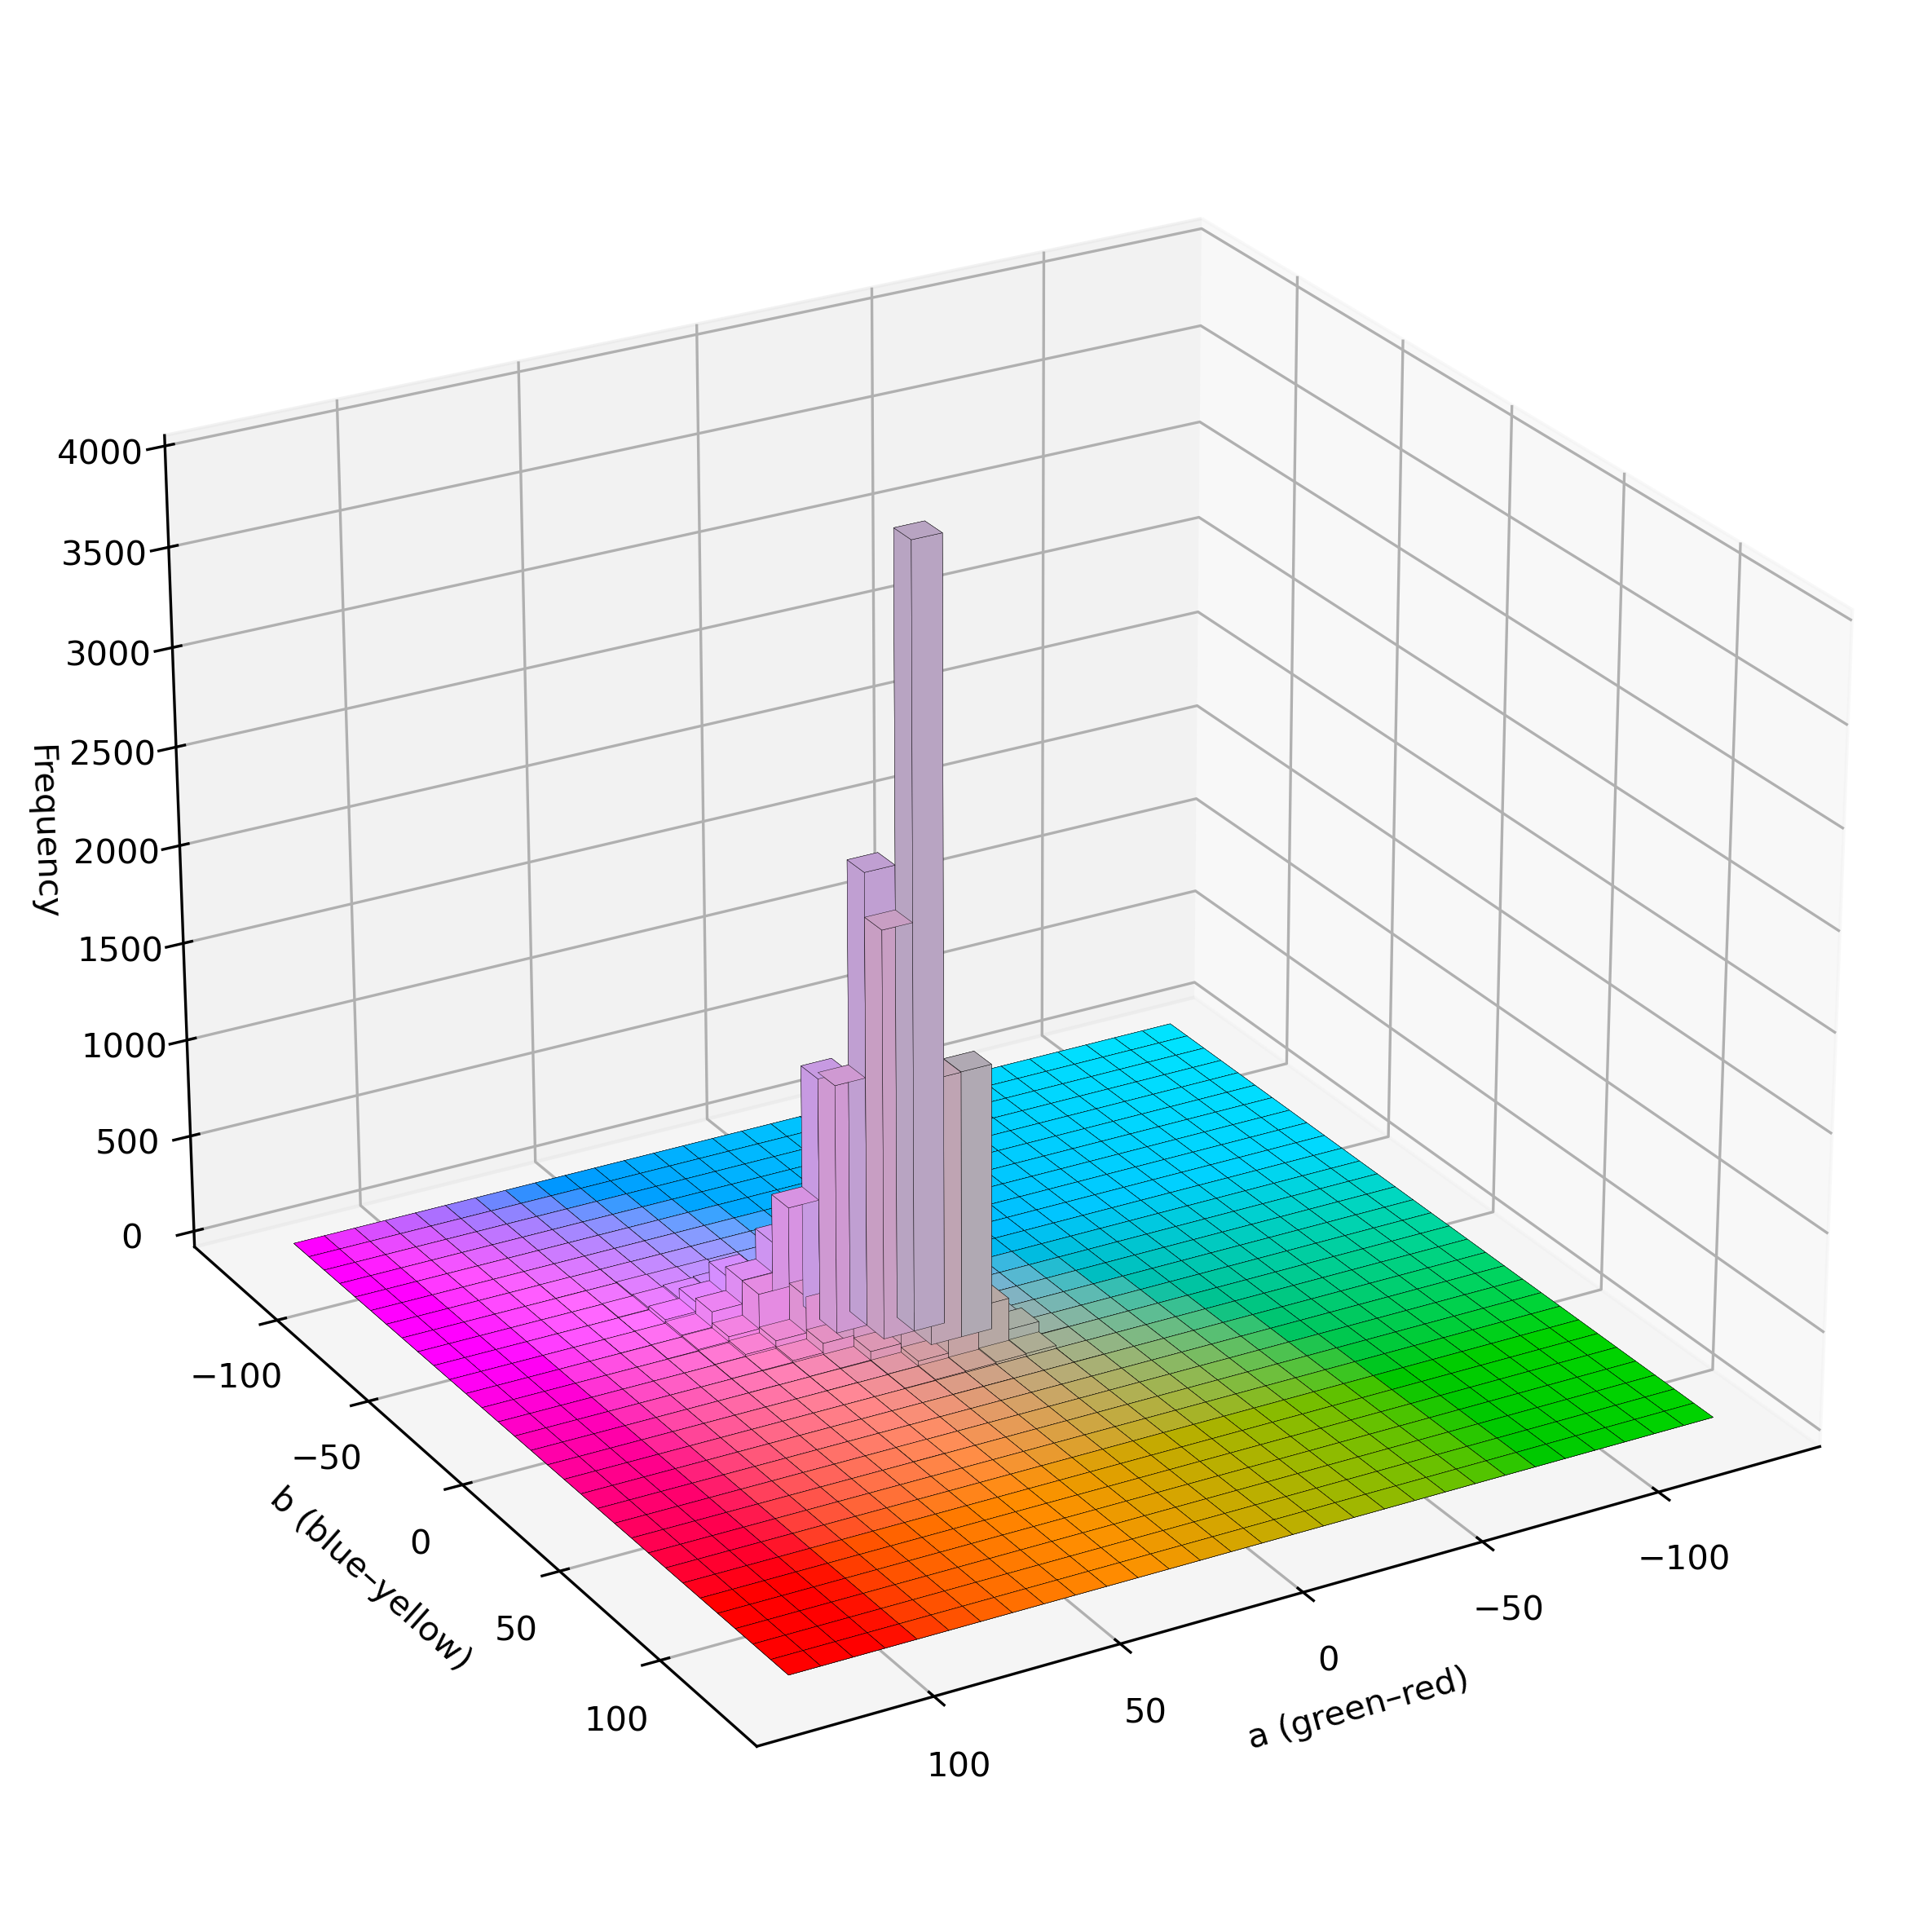

In [9]:
# bin definitions
num_x_bins = 30
num_y_bins = 30
# make the actual histogram object
hist, xedges, yedges = np.histogram2d(a, b, bins=[num_x_bins, num_y_bins],range=[[-128,128],[-128,128]])

# the the center of each bin
a_centers = (xedges[:-1] + xedges[1:]) / 2
b_centers = (yedges[:-1] + yedges[1:]) / 2

# pick a default L for all bins -- this is arbitrary -- we're just looking at hue differences here
default_L = 70#L.mean()

# build mean_lab grid
mean_lab = np.zeros((num_x_bins, num_y_bins, 3), dtype=float)
for i in range(num_x_bins):
    for j in range(num_y_bins):
        mean_lab[i, j] = [ default_L,
                           a_centers[i],
                           b_centers[j] ]

# convert entire grid to srgb.... I think  this is what bar3d is going to want
flat_rgb = lab2rgb(mean_lab[np.newaxis, ...]).reshape(-1, 3)

# line up all of our data
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')
xpos = xpos.ravel(); ypos = ypos.ravel()
#xpos = xpos.flatten(); ypos = ypos.flatten()
zpos = np.zeros_like(xpos)
dx = (xedges[1] - xedges[0]) * np.ones_like(zpos)
dy = (yedges[1] - yedges[0]) * np.ones_like(zpos)
dz = hist.ravel()

# plot
fig = plt.figure(figsize=(10, 8),dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz,
         color=flat_rgb,
         shade=False,
         edgecolor='black',
         linewidth=.1)

ax.set_xlabel('a (green–red)')
ax.set_ylabel('b (blue–yellow)')
ax.set_zlabel('Frequency')
ax.view_init(elev=25, azim=60)
plt.tight_layout()
plt.savefig('./k1_hist_v1.pdf')
plt.show()

### rotate 180 degrees

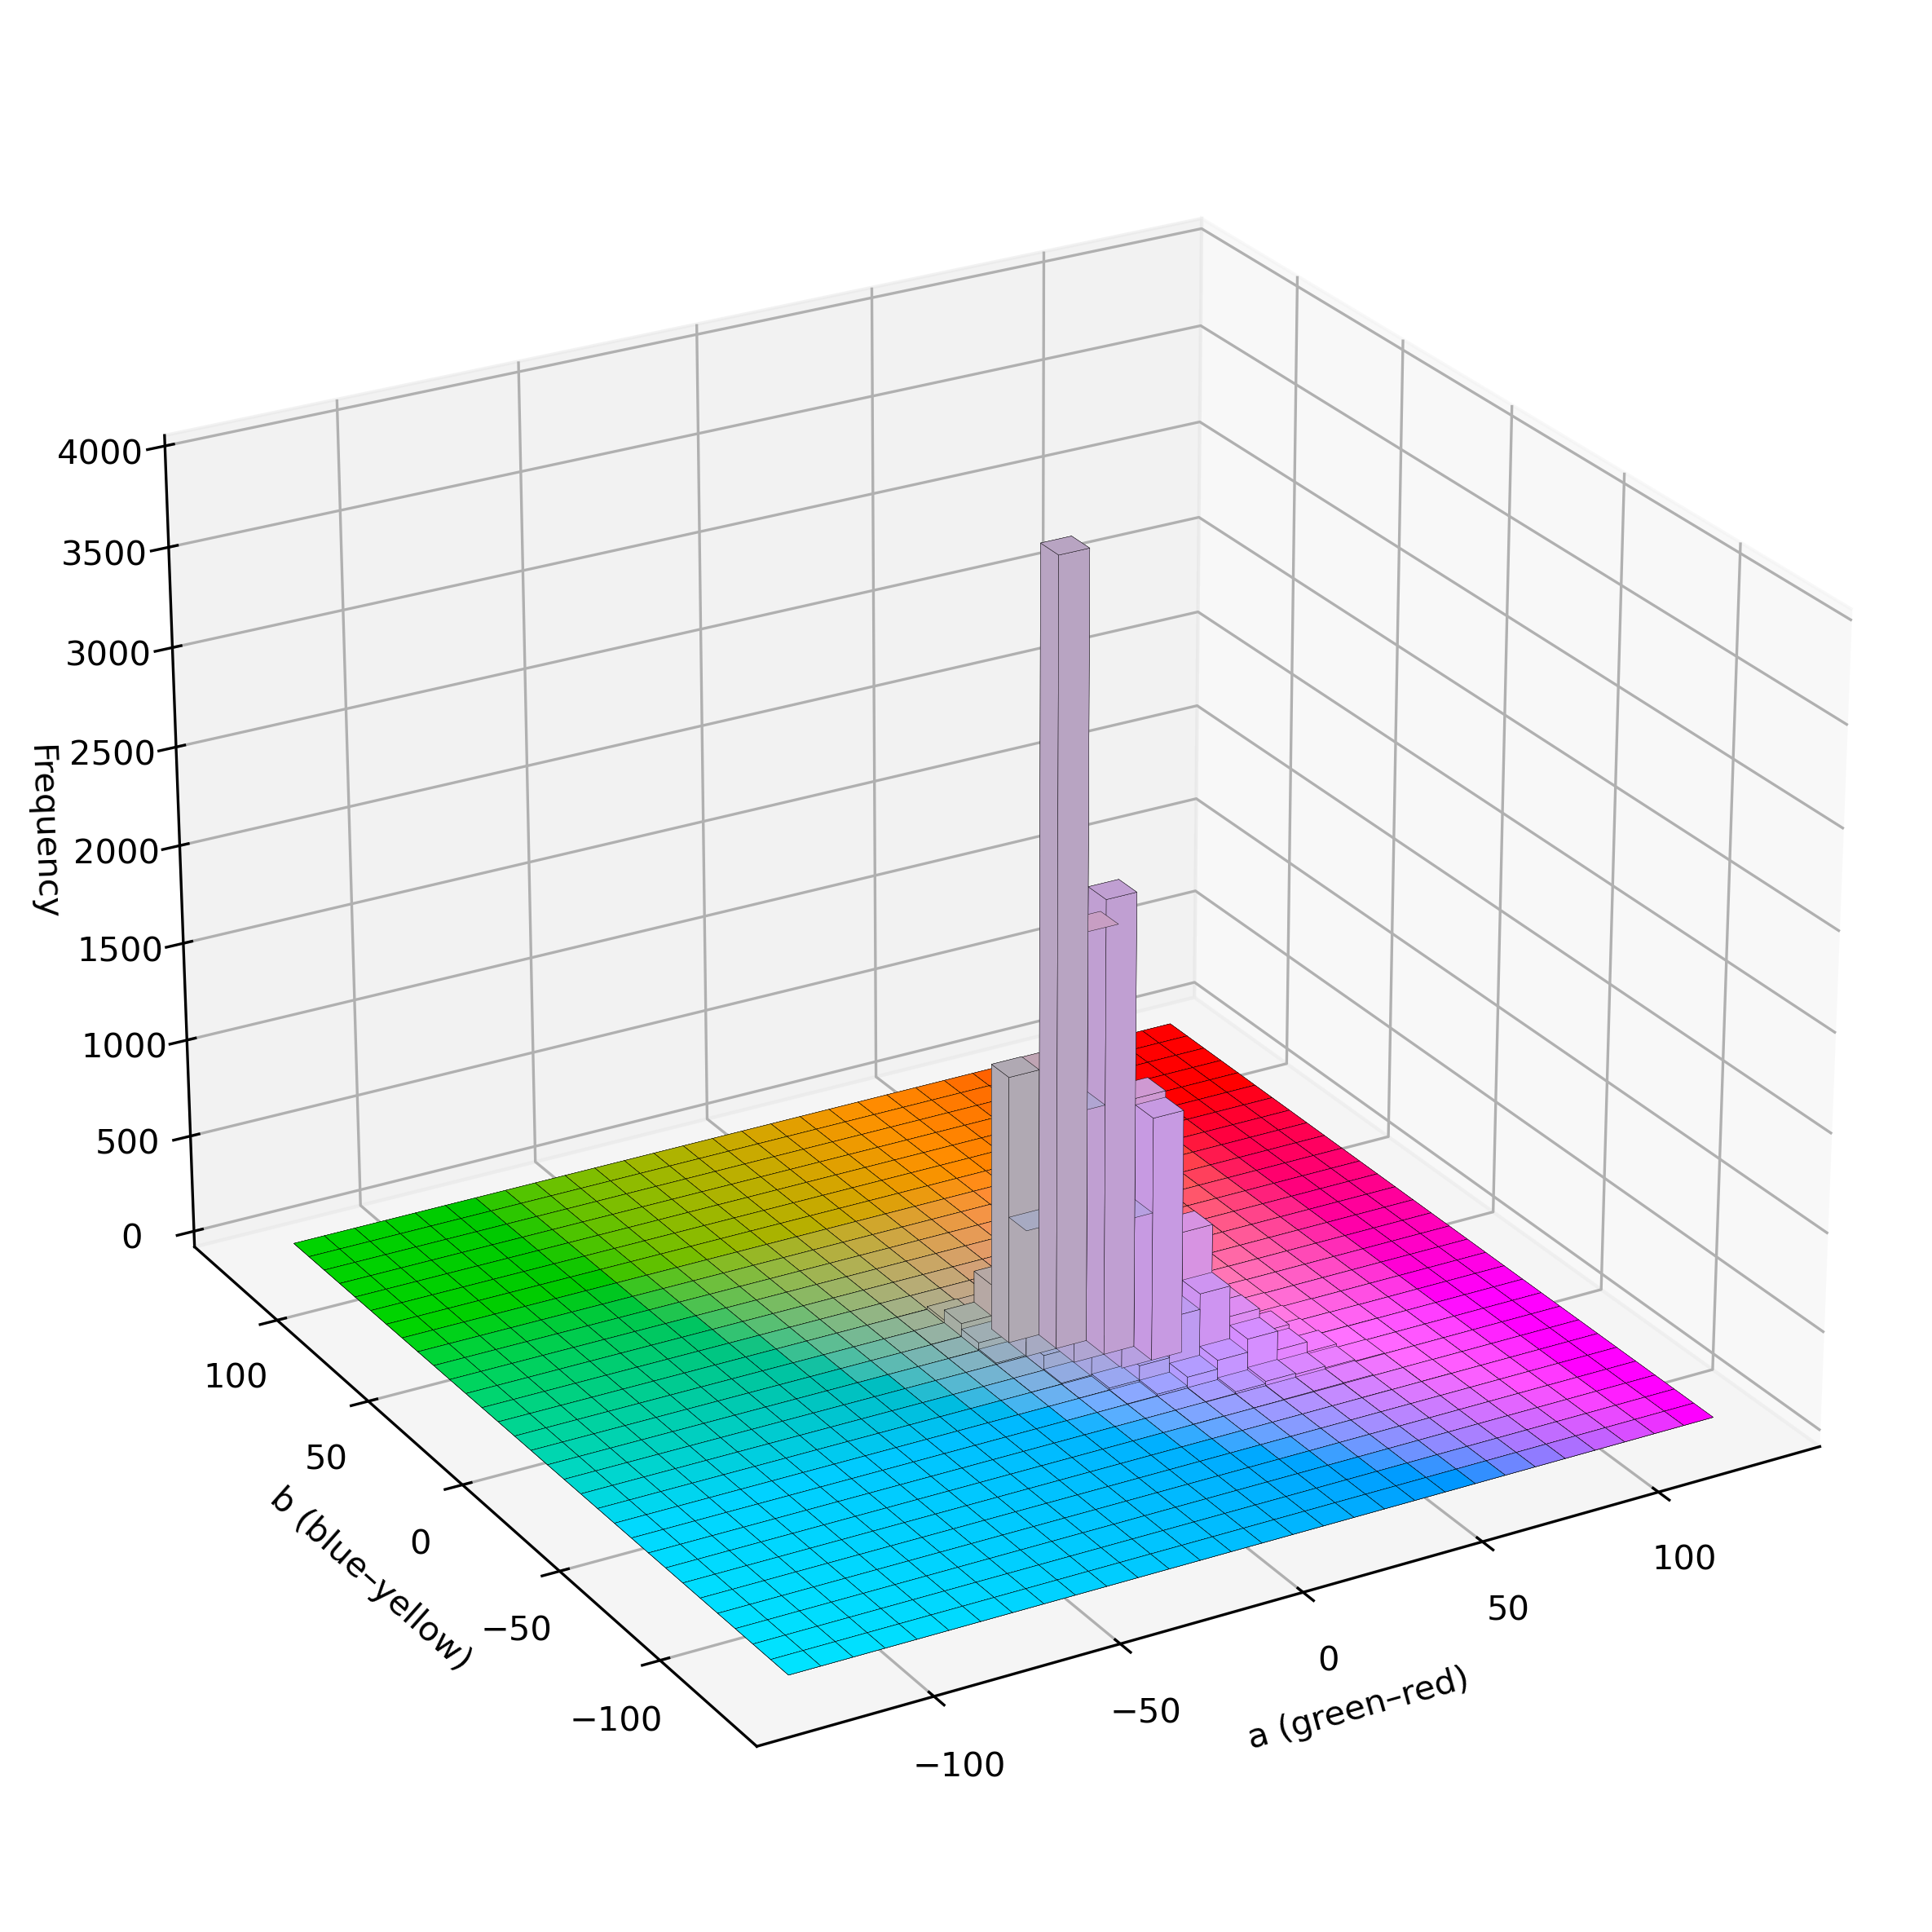

In [10]:
# bin definitions
num_x_bins = 30
num_y_bins = 30
# make the actual histogram object
hist, xedges, yedges = np.histogram2d(a, b, bins=[num_x_bins, num_y_bins],range=[[-128,128],[-128,128]])

# the the center of each bin
a_centers = (xedges[:-1] + xedges[1:]) / 2
b_centers = (yedges[:-1] + yedges[1:]) / 2

# pick a default L for all bins -- this is arbitrary -- we're just looking at hue differences here
default_L = 70#L.mean()

# build mean_lab grid
mean_lab = np.zeros((num_x_bins, num_y_bins, 3), dtype=float)
for i in range(num_x_bins):
    for j in range(num_y_bins):
        mean_lab[i, j] = [ default_L,
                           a_centers[i],
                           b_centers[j] ]

# convert entire grid to srgb.... I think  this is what bar3d is going to want
flat_rgb = lab2rgb(mean_lab[np.newaxis, ...]).reshape(-1, 3)

# line up all of our data
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing='ij')
xpos = xpos.ravel(); ypos = ypos.ravel()
#xpos = xpos.flatten(); ypos = ypos.flatten()
zpos = np.zeros_like(xpos)
dx = (xedges[1] - xedges[0]) * np.ones_like(zpos)
dy = (yedges[1] - yedges[0]) * np.ones_like(zpos)
dz = hist.ravel()

# plot
fig = plt.figure(figsize=(10, 8),dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz,
         color=flat_rgb,
         shade=False,
         edgecolor='black',
         linewidth=.1)

ax.set_xlabel('a (green–red)')
ax.set_ylabel('b (blue–yellow)')
ax.set_zlabel('Frequency')
ax.view_init(elev=25, azim=240)
plt.tight_layout()
plt.savefig('./k1_hist_v2.pdf')
plt.show()